In [2]:
# Import / install required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import requests
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [3]:
# Open target URL.
html = urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# Create BeautifulSoup web-parser.
soup = BeautifulSoup(html, 'html.parser')

# Find attribute table, scrap data and clean text.
table = soup.find('table', {'class': 'wikitable sortable'})
rows = table.find_all('tr')
list_rows = []

for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',str_cells))
    if len(clean2) > 2:
        list_rows.append(clean2.strip('[]')[:-1])
    else:
        continue
 
# Create dataframe of all collected web data.
df = pd.DataFrame(list_rows)
postalcode_df = df[0].str.split(',', expand=True)
postalcode_df.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Remove rows were "Borough" = "Not Assinged" then group neighborhoods by Borough.
for column in postalcode_df.columns.values:
    postalcode_df[column] = postalcode_df[column].str.strip()

postalcode_df = postalcode_df[postalcode_df.Borough != 'Not assigned'].reset_index(drop=True)
postalcode_df.loc[(postalcode_df.Neighborhood == 'Not assigned'), 'Neighborhood'] = postalcode_df[postalcode_df.Neighborhood == 'Not assigned'].Borough.item()
postalcode_df = postalcode_df.groupby(['PostalCode','Borough']).Neighborhood.unique().apply(lambda x: ', '.join(x)).reset_index()
postalcode_df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [4]:
# Check DataFrame shape.
postalcode_df.shape

(103, 3)

In [5]:
# Read in coordinate data for gathered postal codes.
df=pd.read_csv('https://cocl.us/Geospatial_data')
df.columns = ['PostalCode', 'Latitude', 'Longitude']
df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Combine coordinates and Borough / Neighborhood DataFrames.
coordinate_df = postalcode_df.join(df.set_index('PostalCode'), on='PostalCode')
coordinate_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [7]:
# Check DataFrame shape.
coordinate_df.shape

(103, 5)

In [8]:
# Retrieve all Borough names.
coordinate_df.Borough.unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke', "Queen's Park"], dtype=object)

In [9]:
# Remove all boroughs withough "Toronto" in the name.
for borough in coordinate_df.Borough.unique():
    if "Toronto" not in borough:
        coordinate_df = coordinate_df[coordinate_df.Borough != borough]
        
coordinate_df.Borough.unique()

array(['East Toronto', 'Central Toronto', 'Downtown Toronto',
       'West Toronto'], dtype=object)

In [10]:
coordinate_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [11]:
# Store Foursquare credentials and parameters.
CLIENT_ID = 'SQS5S22OXQJAJ1BMBU4H1P4NBDN5AMBTGIRT51FCBOJJ02JS' 
CLIENT_SECRET = 'F2UOU4HIYKUN5TLJ3RUKLZN5NH0INO0OQFBN0MYO0CRCPZRY' 
VERSION = '20180605' 
LIMIT = 100
radius = 500

In [13]:
# Retrieve venue data from Foursquare.
venues_list=[]
for name, lat, lng in zip(coordinate_df['Neighborhood'], 
                          coordinate_df['Latitude'], 
                          coordinate_df['Longitude']):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

toronto_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
toronto_venues.columns = ['Neighborhood', 
                         'Neighborhood Latitude', 
                         'Neighborhood Longitude', 
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
3,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [14]:
# Remove "Neighborhood" from list of venues
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",99,99,99,99,99,99
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",23,23,23,23,23,23
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17


In [15]:
# Print number of unique catagories.
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 uniques categories.


In [16]:
# Print top 120 most common venue types.
toronto_venues['Venue Category'].value_counts().head(10)

Coffee Shop            166
Café                    88
Restaurant              52
Italian Restaurant      42
Bar                     40
Bakery                  39
Hotel                   35
Park                    34
Japanese Restaurant     29
Pizza Place             28
Name: Venue Category, dtype: int64

In [17]:
# Create table of venues per neighborhood.
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Check DataFrame shape.
toronto_onehot.shape

(1702, 233)

In [19]:
# Aggregate neighborhood venues by means.
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.020202,0.0,0.0,...,0.0,0.0,0.0,0.020202,0.0,0.0,0.010101,0.0,0.010101,0.0
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.0,0.000000,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


In [20]:
# Check DataFrame shape.
toronto_grouped.shape

(39, 233)

In [39]:
# Create table of most common venues per neighborhood.
# Define function.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Café,Steakhouse,Asian Restaurant,Bakery,Restaurant,Cosmetics Shop,Sushi Restaurant,Thai Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Farmers Market,Beer Bar,Steakhouse,Seafood Restaurant,Greek Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Nightclub,Coffee Shop,Café,Breakfast Spot,Grocery Store,Bakery,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Smoke Shop,Auto Workshop,Brewery,Spa,Burrito Place,Farmers Market,Fast Food Restaurant,Butcher,Restaurant,Recording Studio
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Boat or Ferry,Airport,Airport Food Court,Bar,Rental Car Location,Harbor / Marina


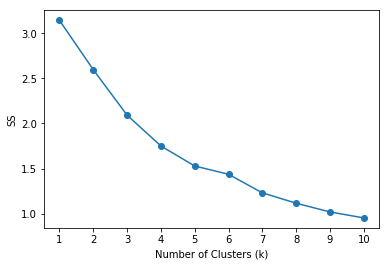

In [24]:
# Conduct Elbow Sum-of-Squares test on clustering DataFrame.
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

k_range = range(1,11)
sum_of_squares = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(toronto_grouped_clustering)
    sum_of_squares.append(KM.inertia_)
    
plt.plot(k_range, sum_of_squares, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

In [30]:
# Conduct silhouette test on clustering DataFrame.
from sklearn.metrics import silhouette_samples, silhouette_score

best=0

for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(toronto_grouped_clustering)
    silhouette_avg = silhouette_score(toronto_grouped_clustering, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.44278947170816607
For n_clusters = 3 The average silhouette_score is : 0.4570582441910987
For n_clusters = 4 The average silhouette_score is : 0.46663783740658776
For n_clusters = 5 The average silhouette_score is : 0.4658194352354087
For n_clusters = 6 The average silhouette_score is : 0.35490217187738193
For n_clusters = 7 The average silhouette_score is : 0.22178531204928775
For n_clusters = 8 The average silhouette_score is : 0.16771764585186405
For n_clusters = 9 The average silhouette_score is : 0.152949235805958
For n_clusters = 10 The average silhouette_score is : 0.11140765152282181
Optimal KMeans n_clusters parameter: 4


In [34]:
# run k-means clustering.
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# Print count of neighborhoods per cluster.
pd.Series(kmeans.labels_).value_counts()

0    35
2     2
3     1
1     1
dtype: int64

In [40]:
# add clustering labels.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = coordinate_df.drop('PostalCode', axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood.
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,The Beaches,43.676357,-79.293031,0,Other Great Outdoors,Coffee Shop,Health Food Store,Trail,Pub,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store
41,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Fruit & Vegetable Store,Pub,Pizza Place
42,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Pet Store,Food & Drink Shop,Burger Joint,Burrito Place,Liquor Store,Italian Restaurant,Fast Food Restaurant,Fish & Chips Shop,Steakhouse
43,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Brewery,Gastropub,Bakery,American Restaurant,Italian Restaurant,Yoga Studio,Convenience Store,Sandwich Place
44,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Swim School,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [41]:
# Import Nominatim.
from geopy.geocoders import Nominatim

# Retrieve coordinates for Toronto.
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [43]:
# Create mpa visual with clustered neighborhoods.
# Create folium map.
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, min_zoom = 12, max_zoom=12)

# Set color scheme for the clusters.
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map.
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
df_cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,The Beaches,Other Great Outdoors,Coffee Shop,Health Food Store,Trail,Pub,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store
41,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Fruit & Vegetable Store,Pub,Pizza Place
42,"The Beaches West, India Bazaar",Sandwich Place,Pet Store,Food & Drink Shop,Burger Joint,Burrito Place,Liquor Store,Italian Restaurant,Fast Food Restaurant,Fish & Chips Shop,Steakhouse
43,Studio District,Café,Coffee Shop,Brewery,Gastropub,Bakery,American Restaurant,Italian Restaurant,Yoga Studio,Convenience Store,Sandwich Place
45,Davisville North,Pizza Place,Hotel,Sandwich Place,Food & Drink Shop,Department Store,Breakfast Spot,Gym,Park,Concert Hall,Dim Sum Restaurant


In [45]:
for i, column in enumerate (df_cluster_0.columns[1:]):
    if i < 3:
        print(column + ':')
        print(df_cluster_0[column].value_counts().head())
        print('')

1st Most Common Venue:
Coffee Shop           14
Café                   3
Sandwich Place         2
Pizza Place            2
Mexican Restaurant     1
Name: 1st Most Common Venue, dtype: int64

2nd Most Common Venue:
Café              9
Coffee Shop       6
Bakery            3
Sandwich Place    2
Pharmacy          1
Name: 2nd Most Common Venue, dtype: int64

3rd Most Common Venue:
Restaurant            5
Hotel                 4
Park                  3
Brewery               2
Italian Restaurant    2
Name: 3rd Most Common Venue, dtype: int64



In [46]:
df_cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,Park,Bus Line,Swim School,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [47]:
df_cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Rosedale,Park,Playground,Trail,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
64,"Forest Hill North, Forest Hill West",Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [48]:
df_cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,Pool,Garden,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
